# Final Project, Numerical Analysis, 2018-2019
This is a notebook containing my solution of the assignments.
In the course of the notebook, I will justify my design in terms of time optimisation.

# Preparations
Before starting with the actual assignments, I prepare myself with some preliminary definitions and rearrangings.

First of all, I load the rquired data from the `mnist.pnz` file, as explained in the original assignment notebook.

In [1]:
%pylab inline
img_rows, img_cols = 28, 28

arc = load('mnist.npz')

x_train = arc['arr_0']
y_train = arc['arr_1']
x_test  = arc['arr_2']
y_test  = arc['arr_3']

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Populating the interactive namespace from numpy and matplotlib
(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Then, I create a context-manager class Timer(), which I will use to measure times and optimise my strategies.

In [2]:
## to measure time
import time

class Timer():
    def __enter__(self):
        self._t0 = time.perf_counter()
    
    def __exit__(self,type,value,traceback):
        self._t1 = time.perf_counter()
        print("Time spent: [%0.8f] secs" % (self._t1-self._t0))

Here I load various libraries, which are needed in the course of the notebook: to plot results, to print arrays and matrices in a nice way, to integrate, to define a ball tree.

Notice that, although I loaded Simpson's quadrature method from `scipy.integrate`, I do not actually use it. Indeed, I will implement my quadrature function, which exploits the properties of the MNIST dataset and runs faster, whithout losing much accuracy.

In [3]:
## libraries for various tasks

import matplotlib.pyplot as plt # for plots
from pprint import pprint # to print matrices in nice ways
from scipy.integrate import simps as quad ## to integrate (but I will not use it)
from sklearn.neighbors import * ## to define a ball tree

It is convenient to reshape the images as vectors. This is somewhat optional up to Assignment 7, but it is mandatory for Assignment 8, because the `BallTree` function accepts only vectors. Therefore, I shall implement Assignments 1-7 in such a way that they are already adapted to vectorised form.

In [4]:
## it is convenient to vectorize the images
v_train = [x_train[i].reshape(28*28) for i in range(x_train.shape[0])]
v_test = [x_test[i].reshape(28*28) for i in range(x_test.shape[0])]

Finally, I define some recurrent variables.

In [8]:
## recurrent variables
S = 1600
L = shape(x_train)[0] ## 64000
T = shape(x_test)[0] ## 10**4
test_range = 1000

# Assignment 1
I define the three norms, $D\infty$, $D1$ and $D2$.

In $D2$ I do not take a `sqrt` of the result, because it is a waste of time and does not affect the final result.

Notice that, as they are written, the distances are well defined for both matricial and vectorial forms of the images.

In [9]:
## ASSIGNMENT 1

## define d_infty
def _Dinfty(a,b):
    return abs(a-b).max()

## define d_one
def _D1(a,b):
    return abs(a-b).sum()

## define d_two
def _D2(a,b):
    return square(a-b).sum()

In the following, it will be useful to have the distances in a set list, and a dictionary which assign a name string to each dictionary. In the course of the notebook, we will update these objects when new distances are defined.

In [127]:
## define distances array and names dictionary

distances = [_D1,_D2,_Dinfty]
names = {_D1:'D1',_D2:'D2',_Dinfty:'D_infty'}

# Assignment 2
I write a function `my_func()` which computes the $(N,N)$ distance matrix between the first $N$ images of the set `x`.

In [11]:
## ASSIGNMENT 2
## function returning matrix of distances

def my_func(x,N,dist):
    X=x[:N]
    ret = zeros((N,N))
    for i in range(N):
        for j in range(i+1,N):
            ret[i,j] = dist(X[i],X[j])
    return ret+ret.T

# Assignment 3
Plot the distance matrix between the first 100 elements of `x_train`, for each of the three distances defined above. I use the vectorised form `v_train`.

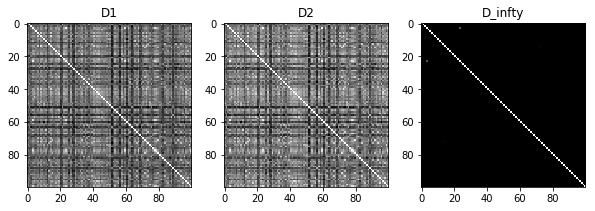

In [12]:
## ASSIGNMENT 3

fig, axs = plt.subplots(1,3,figsize=(10,6))
for ax, distance in zip(axs, distances):
    ax.imshow(my_func(v_train,100,distance),cmap='gray_r')
    ax.set_title(names[distance].capitalize())
plt.show()

## Assignments 4 - 5
I implement Assignments 4 and 5 together. They consist in computing the error with the **leave-one-out** strategy, for each distance defined above and for different number $N=[100,200,400,800,1600]$ of training images.

The heaviest part of the exercise is the computation of the distance matrices. Therefore I precompute them. I precompute them directly for $N=1600$, and I will slice them appropriately when lower $N$ is needed. (Recall from above that `S=1600`.)

In [13]:
## ASSIGNMENT 4 and 5
## precompute heavy part of the computation

with Timer():
    M1 = my_func(v_train,S,_D1)
    M2 = my_func(v_train,S,_D2)
    M3 = my_func(v_train,S,_Dinfty)

Time spent: [18.58645361] secs


It is convenient to define a list of distance matrices and a list of dimensions $N$.

In [124]:
methods = [M1,M2,M3]
dims = [100,200,400,800,1600]

I define a function `efficiency()` which implements the leave-one-out strategy and plots the results.

The function is flexible, in that it calls elements from the objects defined above: `methods`, `dims`, `distances` and `names`. Therefore we can use it also later, without modifications, by just updating and/or redefining the above objects.

In [125]:
## set difference dimensions to test efficiency

def efficiency():
    errors = []
    ## computation of the relative errors
    for num in dims:
        loc_errors=[]
        for matrix in methods:
            error_counter = 0.
            for i in range(num):
                M = matrix[i:i+1][0][:num]
                MM = delete(M,i)
                arg = argmin(MM) + int(argmin(MM)>=i)
                digit = y_train[arg]
                if y_train[i] != digit:
                    error_counter +=1
            loc_errors.append(error_counter*100/num)
        errors.append(loc_errors)
    for k in range(size(distances)):
        plt.plot(dims,[errors[i][k] for i in range(size(dims))],'-o',label=names[distances[k]])
    plt.legend()
    plt.xlabel('slice dimesnion')
    plt.ylabel('percentage error')
    plt.title('Compare different norms')
    plt.grid()
    plt.show()
    return errors

Now we plot the results and print the error matrix, which coincides with the one shown in the original assignments. **Notice that, w.r.t. the original assignments, I prefer to multiply the errors by 100, in such a way to have a percentual error.**

From the plot, we see that the distance $D\infty$ is much less performant. 

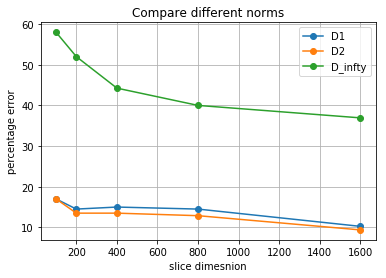

[[17.0, 17.0, 58.0],
 [14.5, 13.5, 52.0],
 [15.0, 13.5, 44.25],
 [14.5, 12.875, 40.0],
 [10.25, 9.375, 36.9375]]


In [145]:
errors = efficiency()
pprint(errors)

Therefore, we focus in more detail on the difference between $D1$ and $D2$.

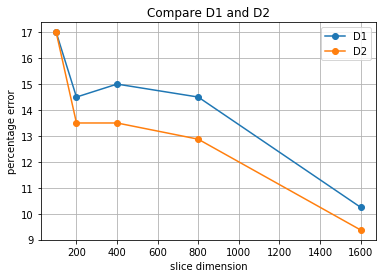

In [53]:
## Focus on the difference between D1 and D2

plt.plot(dims,[errors[i][0] for i in range(size(dims))],'-o',label='D1')
plt.plot(dims,[errors[i][1] for i in range(size(dims))],'-o',label='D2')

plt.legend()
plt.title('Compare D1 and D2')

plt.xlabel('slice dimension')
plt.ylabel('percentage error')

plt.grid()
plt.show()

Here below, I do some extra work.

I define a function `classify()`, which associates a number to any image in a set `z`, by computing its distance `dist` from the members of a training set `X`. 

In [23]:
## define the classify function for later usage
def classify(z,dist,X):
    all_distances = [dist(z,x) for x in X]
    digit = y_train[argmin(all_distances)]
    return digit

I also define a function `my_test()`, which computes the classification errors of a test set `X`, relative to a distance `dist` and a training set `Z`.

Notice that this is the same kind of test that I will have to do in Assignment 8, although with a different algorithm. Therefore, it is useful to do it, in order to define needed objects in advance and anticipate possible problems not related to the details of a ball-tree.

In [24]:
## test x_test angainst y_test with the distance D2
## notice that, for consistency, if you test x_train vs y_train
## then you should get 0.000 errors with any norm: try it!

## my_test function

def my_test(X,Y,dist,Z):
    errors = 0.
    for i in range(test_range):
        candidate = classify(X[i],dist,Z)
        if candidate != Y[i]:
            errors += 1
    errors = errors*100/test_range
    print("percentage error: %0.5f" % errors)

The typical test that I perform is on `v_test[:1000]` against `v_train[:1600]`.

In [25]:
with Timer():
    my_test(v_test[:test_range],y_test[:test_range],_D2,v_train[:S])

percentage error: 14.10000
Time spent: [7.21637617] secs


# Assignment 6
In this assignment, we have to implement a new distance based on integrals and gradients.

Regarding the integrals, I could do them with the `scypy.integrate` library. However, I implemented my own integration function `my_quad()`, because I recognized the existence of a faster method. This method is not general, but it is specific of the boundary conditions of the images in our sets.

Let me explain. Suppose we integrate using a Newton quadrature with trapezoids. Our images are discrete functions $f$, defined on a grid with unit spacing. Therefore the integral reads (restricting for simplicity to the one dimension)

$$ I = \sum_{i=0}^{N-1}\frac{f(i)+f(i+1)}{2}. $$

But this can be rewritten as
$$ I = \left(\sum_{i=0}^N f(i)\right)-\frac{f(0)+f(N)}{2} $$

However, given that our images are null at the boundaries, the integral eventually reduces to the sum of all the points.

This is essentially my quadrature function. It is faster because it uses the built-in `sum` function of numpy arrays.

In [26]:
## ASSIGNMENT 6

def my_quad(obj):
    return obj.sum()

Before defining the new distance, I precompute some integrals and set up several useful objects:
- compute the integrals $$ I[i] = \int_\Omega x[i] $$
- compute the densitized images $$ z[i] = \frac{x[i]}{I[i]} $$ and their vectorial forms $w[i]$
- compute the gradients of the $z[i]$'s (notice that you have to use the matricial forms, because the gradients are in 2D)

Finally, I construct a family of "super-vectors" `xd[i]` which contain, for each `i`, $$xd[i]=(w[i],\partial_xz[i],\partial_yz[i])$$

In [27]:
## compute all the integrals
integrals = [ my_quad(x_train[i]) for i in range(L) ]

## compute the new set of train ...
z_train = [x_train[i]/integrals[i] for i in range(L)]
w_train = [z_train[i].reshape(28*28) for i in range(L)]

## and their 2D gradients ...
## use z_train because it's 2D!
gradients = [gradient(z_train[i]) for i in range(L)]

## finally, construct a collection of big images, containing also the components of the gradients
xd_train=[append([w_train[i],gradients[i][0].reshape(28*28)],gradients[i][1].reshape(28*28))\
          for i in range(L)]

I define two new distances. The second one was not mentioned in the original assignments. I implemented becaus it is faster and gives better results w.r.t. the first. Moreover, in the second distance you do not compute any gradient.

The first distance is $$DH1(a,b) = \int_\Omega|\nabla(a-b)|^2+(a-b)^2$$
I define it without the square root, because it is not needed for our purposes.

The second distance is $$\text{my-dist}(a,b)=\int_\Omega|a-b|$$.

Notice that, since I am identifying the integral with a sum over all points, the two distances are equivalent to:
- $ DH1(x[i],x[j]) = D2(xd[i],xd[j])$
- $ \text{my-dist}(x[i],x[j]) = D1(w[i],w[j]) $

In [28]:
## define new distances

## notice that I do not sqrt in H1
def _Dh1(a,b):
    return _D2(a,b)

## this is my_distance
## which is just D1, but with z_train instead of x_train ;)
def my_dist(a,b):
    return _D1(a,b)

Now I repeat the same analysis of Assignments 4-5: I compute the distance matrices of the two new distances, I update the various object-lists and I plot the efficiency. I compare the two new distances with $D2$, which was the best performant in the previous cases. From the plot, you see that $\text{my-dist}$ performs better than both $D2$ and $DH1$.

In [30]:
with Timer():
    M4 = my_func(xd_train[:S],S,_Dh1)
with Timer():
    M5 = my_func(w_train[:S],S,my_dist)

Time spent: [8.31417595] secs
Time spent: [5.81754534] secs


In [54]:
## update data for efficiency comparison
methods = [M2,M4,M5]
distances=[_D2,_Dh1,my_dist]
names[_Dh1]='H1'
names[my_dist]='my_dist'

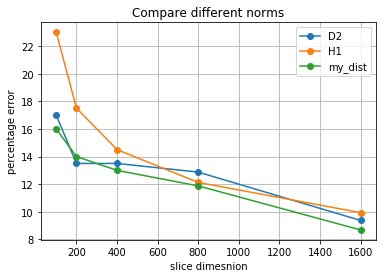

[[17.0, 23.0, 16.0],
 [13.5, 17.5, 14.0],
 [13.5, 14.5, 13.0],
 [12.875, 12.125, 11.875],
 [9.375, 9.9375, 8.6875]]


In [55]:
errors3=efficiency()
pprint(errors3)

Finally, I also run `my-test` for the new distances. In doing so, I create the test objects that will be also needed for Assignment 8.

In [33]:
## create objects to test new distances
integrals = [ my_quad(x_test[i]) for i in range(T) ]

## compute the new set of train ...
z_test = [x_test[i]/integrals[i] for i in range(T)]
w_test = [z_test[i].reshape(28*28) for i in range(T)]

## and their gradients ...
gradients = [gradient(z_test[i]) for i in range(T)]

## finally, construct a collection of big images, containing also the components of the gradients
xd_test=[append([w_test[i],gradients[i][0].reshape(28*28)],gradients[i][1].reshape(28*28))\
         for i in range(T)]

In [35]:
with Timer():
    print('with H1: '), my_test(xd_test[:test_range],y_test[:test_range],_Dh1,xd_train[:S])
with Timer():
    print('with my_dist: '), my_test(w_test[:test_range],y_test[:test_range],my_dist,w_train[:S])

with H1: 
percentage error: 15.10000
Time spent: [11.75094360] secs
with my_dist: 
percentage error: 14.10000
Time spent: [7.37443709] secs


# Assignment 7
In this Assignment I implement the Morge-Ampere distance. In doing so, I need to solve a Laplacian equation of the form $$\Delta \phi = a-b$$
where $a,b\in$ `z_train`, and with boundary conditions $\phi|_{\partial\Omega}=0$

Notice that the Eq. is linear. Therefore, assuming that the solution is unique, one has $\phi = \phi_a-\phi_b$, where $\Delta\phi_a=a$ and $\Delta\phi_b=b$, and with the same vanishing boundary conditions on $\phi_a$ and $\phi_b$. 

Therefore it will be sufficient to solve the equation for the single images in `z_train`.

Let me implement the objects needed to solve the problem. First, I impelement the finite-element approximation of the Laplacian operator. This is not strictly needed, but I will use it to check the goodness of my solutions. 

In [37]:
## ASSIGNMENT 7

def Laplacian(obj):
    res = zeros((28,28))
    for i in range(1,27):
        for j in range(1,27):
            res[i][j] = obj[i+1][j]+obj[i-1][j]-4*obj[i][j]+obj[i][j-1]+obj[i][j+1]
    return res

I will solve the Laplacian equation with the finite-element Jacobi method. The details are explained in "Arnold, A concise introduction to numerical analysis", Chapter 6, Section 2.

In brief, one reduces the problem to the solution of a linear system $$ \mathbb{J}\cdot\vec{\phi_a} = \vec{a}$$
where $\mathbb{J}$ is the Jacobi matrix, while the vector arrow means that $\phi_a$ and $a$ are interpreted in their vectorised form.

Therefore, I just need to implement the Jacobi matrix (see Arnold oag. 155) for the problem at hand, and to invert it.

**Notice that the function Lsolve() returns the solution in the matrix form.**

In [38]:
## Define a function which returns the inverse of the Jacobi matrix
def Jmatrix(size1):
    size2 = size1*size1

    ## Define the building blocks
    a = ones((size1-1,))
    b = -4*ones((size1,))
    m = (diag(a, -1) + diag(b, 0) + diag(a, +1))

    c = zeros((size1,size1))
    for i in range(size1):
        c[i][i]=1

    ## Define the main matrix
    M = np.zeros((size2,size2))
    for d in range(size1):
        M[d*size1:d*size1+size1, d*size1:d*size1+size1] = m
    for d in range(size1-1):
        M[d*size1:d*size1+size1, d*size1+size1:d*size1+2*size1] = c
    for d in range(1,size1):
        M[d*size1:d*size1+size1, d*size1-size1:d*size1] = c
        
    ## reinitialize boundary elements of M
    for i in range(size1):
        M[i,:],M[:,i] = 0,0
        M[i,i] = 1
        M[-1-i,:],M[:,-1-i] = 0,0
        M[-1-i,-1-i] = 1
    for i in range(1,size1-1):
        M[i*size1,:], M[:,i*size1] = 0,0
        M[i*size1+size1,:], M[i*size1+size1,:] = 0,0
        M[i*size1,i*size1] = 1
        M[i*size1+size1,i*size1+size1] = 1
    return linalg.inv(M)
    #return M
    
J = Jmatrix(28)

## Laplacian solver
def Lsolve(rhs):
    #return linalg.solve(J,rhs.reshape(size2)).reshape(size1,size1)
    return dot(J,rhs.reshape(28*28)).reshape(28,28)

To give a demonstration, I solve for $\phi_0$ and $\phi_9$, and I show that $\Delta\phi=z[0]+z[9]$.

Time spent: [0.00237931] secs


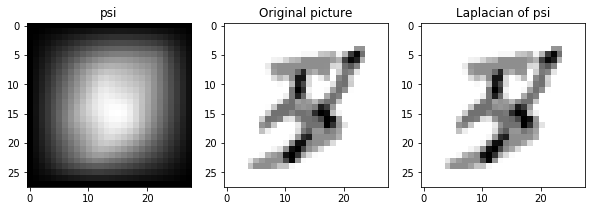

In [39]:
RHS1 = z_train[0]
RHS2 = z_train[9]
with Timer():
    psi1 = Lsolve(RHS1)
    psi2 = Lsolve(RHS2)

## plot the solution and
## verify the coincidence between
## the Laplacian of psi and original picture

fig, axs = plt.subplots(1,3,figsize=(10,10))
axs[0].imshow(psi1+psi2,cmap='gray_r')
axs[1].imshow(RHS1+RHS2,cmap='gray_r')
axs[2].imshow(Laplacian(psi1+psi2),cmap='gray_r')
axs[0].set_title('psi')
axs[1].set_title('Original picture')
axs[2].set_title('Laplacian of psi')
plt.show()

I am now ready to define the new distance. First, I construct all the $\phi$ for each image in `z_train`.

In [41]:
## initialize the set of solutions of the Laplace equation
with Timer():
    phi_train = [Lsolve(z_train[i]) for i in range(L)]

Time spent: [4.12365988] secs


Then I compute their derivatives, and I construct a new set of "super vectors" as in the previous assignments, defined as
$$ \xi[i]=(w[i],\partial_x\phi[i],\partial_y\phi[i]) $$

In [42]:
## Compute the derivatives of psi_train
grad_phi = [gradient(phi_train[i]) for i in range(L)]

## build a larger vectorized object with the gradients
xi_train=[append([w_train[i],grad_phi[i][0].reshape(28*28)],grad_phi[i][1].reshape(28*28))\
          for i in range(L)]

Now, I am ready to define the distances. I define two new distances. The first is the Morge-Ampere distance
$$DMA(a,b) = \int_\Omega(a+b)\cdot|\nabla\phi_{a-b}|^2$$
The second distance was not asked in the assignment, but I implemented by my own (and it will turn out to be the best of all the distances):
$$DMA2(a,b) = \int_\Omega|a-b|\cdot|\nabla\phi_{a-b}|^2$$
Notice that I implemented the new distances in such a way that the two arguments are supervectors of the form $\xi$. This is to uniform the distances definitions, as functions taking only two arguments.

In [43]:
def _Dma(a,b):
    step = 28*28
    p1 = ((a+b)[:step]).reshape(28,28)
    c = (a - b)[step:3*step]
    p2 = (square(c[0:step])+square(c[step:2*step])).reshape(28,28)
    res = matmul(p1,p2)
    return res.sum()


def _Dma2(a,b):
    step = 28*28
    c = (a - b)
    p1 = abs(c[:step]).reshape(28,28)
    p2 = (square(c[step:2*step])+square(c[2*step:3*step])).reshape(28,28)
    res = matmul(p1,p2)
    return res.sum()

I now have all the ingredients to compute the efficiency of the new distances.

In [44]:
with Timer():
    M6 = my_func(xi_train[:S],S,_Dma)
with Timer():
    M7 = my_func(xi_train[:S],S,_Dma2)

Time spent: [26.82950130] secs
Time spent: [29.18830660] secs


In [56]:
## update data for efficiency comparison
methods = [M2,M5,M6,M7]
distances=[_D2,my_dist,_Dma,_Dma2]
names[_Dma]='MA'
names[_Dma2]='MA2'

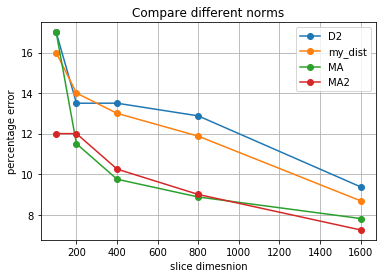

[[17.0, 16.0, 17.0, 12.0],
 [13.5, 14.0, 11.5, 12.0],
 [13.5, 13.0, 9.75, 10.25],
 [12.875, 11.875, 8.875, 9.0],
 [9.375, 8.6875, 7.8125, 7.25]]


In [57]:
errors4=efficiency()
pprint(errors4)

Finally, I run `my-test` for the new distances.

In [59]:
## create objects to test new distances
phi_test = [Lsolve(z_test[i]) for i in range(T)]

## and their gradients ...
grad_phi2 = [gradient(phi_test[i]) for i in range(T)]

## finally, construct a collection of big images, containing also the components of the gradients
xi_test=[append([w_test[i],grad_phi2[i][0].reshape(28*28)],grad_phi2[i][1].reshape(28*28))\
         for i in range(T)]

In [60]:
with Timer():
    print('with MA: '), my_test(xi_test[:test_range],y_test[:test_range],_Dma,xi_train[:S])
with Timer():
    print('with MA2: '), my_test(xi_test[:test_range],y_test[:test_range],_Dma2,xi_train[:S])

with MA: 
percentage error: 11.40000
Time spent: [27.79257797] secs
with MA2: 
percentage error: 11.10000
Time spent: [25.34754460] secs


# Assignment 8

In [62]:
## Assignment 8

sizes = [800,1600,3200,6400]
distances = [_D1,_D2,_Dh1,my_dist,_Dma,_Dma2]
test = [v_test,v_test,xd_test,w_test,xi_test,xi_test]
train = [v_train,v_train,xd_train,w_train,xi_train,xi_train]
tsize = 10**3

In [79]:
## reset errors
errors = []
errors2 = []

In [64]:
## append to errors[] the errors relative to distance d-th distance
def append(d):
    loc_errors = []
    for N in sizes:
        count = 0.
        tree = BallTree( train[d][:N], leaf_size = 400, metric=distances[d] )
        dist, ind = tree.query(test[d][:tsize], k=1) 
        for i in range(ind.size):
            arg=ind[i][0]
            if y_test[i]!=y_train[arg]:
                count+=1
        loc_errors.append(count*100/tsize)
    errors.append(loc_errors)

In [65]:
with Timer():
    append(0) # append D1
    append(1) # append D2

Time spent: [144.71943401] secs


In [68]:
with Timer():
    append(2) # append DH1
    append(3) # append my_dist

Time spent: [183.41876822] secs


In [74]:
with Timer():
    append(4) # append MA
    append(5) # append MA2

Time spent: [424.71261198] secs


In [77]:
def plot(D):
    for i in D:
        plt.plot(sizes, errors[i],'-o',label=names[distances[i]])
    plt.legend(loc=1)
    plt.tight_layout()
    plt.xlabel('train dimension')
    plt.ylabel('percentage error')
    plt.title('Compare different norms (test dimension = 1000)')
    plt.grid()
    plt.show()

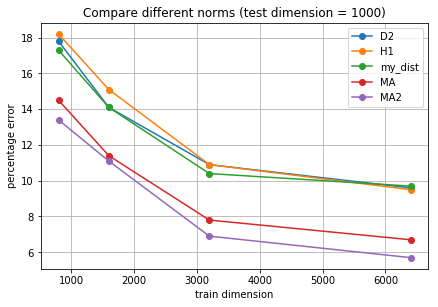

In [78]:
plot(range(1,6))

In [119]:
## append to errors2[] the errors relative to distance d-th distance
def append2(d):
    loc_errors = []
    for N in sizes:
        count = 0.
        tree = BallTree( train[d][:N], leaf_size = 400, metric=distances[d] )
        dist, ind = tree.query(test[d][:tsize], k=10) 
        for i in range(shape(ind)[0]):
            digits = [y_train[arg] for arg in ind[i]]
            digit = digits[argmax(digits)-1]
            if y_test[i]!=digit:
                count+=1
        loc_errors.append(count*100/tsize)
    errors2.append(loc_errors)

In [112]:
def plot2(D):
    for i in D:
        plt.plot(sizes, errors2[i],'-o',label=names[distances[i]])
    plt.legend(loc=1)
    plt.tight_layout()
    plt.xlabel('train dimension')
    plt.ylabel('percentage error')
    plt.title('Compare different norms (test dimension = 1000)')
    plt.grid()
    plt.show()